# 02 — Nettoyage & préparation des données (consommation + météo)

Ce notebook prépare les **datasets propres** utilisés dans la suite du projet *Stress Grid* :

1. **Consommation nationale** : consolidation des fichiers `consommation_YYYY_long.csv` (pas 30 min) → `consommation_clean.parquet`
2. **Météo multi-villes** : nettoyage + contrôle de continuité horaire → agrégation nationale → `weather_national_hourly.parquet`
3. **Alignement temporel** : consommation (resample horaire) + météo nationale (horaire) → `dataset_model_hourly.parquet`

> Remarque : le “trou” 2020 (mai→septembre) est une **absence de données source** et n’est pas imputé dans le baseline.


## 0. Imports & configuration

Le code “lourd” est déporté dans `src/data/` afin de garder ce notebook lisible (orchestration + contrôles).


In [17]:
import pandas as pd
import sys
from pathlib import Path

# Notebook lancé depuis .../notebooks
PROJECT_ROOT = Path.cwd().resolve().parent

# Ajoute la racine du projet en priorité (avant site-packages)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data"
DATA_RAW = DATA_DIR / "raw*"
DATA_PROCESSED = DATA_DIR / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_PROCESSED exists:", DATA_PROCESSED.exists())





PROJECT_ROOT: /home/onyxia/france-grid-stress-prediction
DATA_RAW exists: True
DATA_PROCESSED exists: True


In [18]:
import importlib, sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Trying import src ...")
import src
print("src imported from:", src.__file__ if hasattr(src, "__file__") else src)

print("Trying import src.data ...")
import src.data
print("src.data imported from:", src.data.__file__ if hasattr(src.data, "__file__") else src.data)


Trying import src ...
src imported from: /home/onyxia/france-grid-stress-prediction/src/__init__.py
Trying import src.data ...
src.data imported from: /home/onyxia/france-grid-stress-prediction/src/data/__init__.py


## 1. Consommation électrique — nettoyage et consolidation

- Standardisation des colonnes (`datetime`, `load_mw`)
- Tri temporel + déduplication
- Contrôle simple de continuité (pas attendu = 30 min)
- Export en Parquet


In [19]:
from src.data.consumption_cleaning import ConsumptionCleanConfig, build_consumption_dataset


cfg_cons = ConsumptionCleanConfig(
    raw_dir=DATA_RAW / "consommation",   
    out_path=DATA_PROCESSED / "consommation_clean.parquet",
    pattern="consommation_*_long.csv",
)

df_cons, report_cons = build_consumption_dataset(cfg_cons)






### 1.1 Contrôles rapides

- Bornes temporelles
- Unicité de `datetime`
- Pas de temps observé (distribution des deltas)


In [20]:
df_cons["datetime"].min(), df_cons["datetime"].max(), len(df_cons), df_cons["datetime"].is_unique


(Timestamp('2010-01-01 00:00:00'),
 Timestamp('2024-12-31 23:30:00'),
 252672,
 True)

In [21]:
df_cons = df_cons.sort_values("datetime")
df_cons["datetime"].diff().value_counts().head(10)


datetime
0 days 00:30:00      252669
154 days 00:30:00         1
61 days 00:30:00          1
Name: count, dtype: int64

## 2. Météo — nettoyage, contrôle, agrégation nationale

- Nettoyage : colonnes, datetime (UTC → naïf), doublons (`city`, `datetime`)
- Contrôle de continuité horaire **par ville**
- Agrégation nationale : moyenne horaire sur l’ensemble des villes


In [22]:
from src.data.weather_cleaning import WeatherCleanConfig, build_weather_national_dataset

cfg_w = WeatherCleanConfig(
    raw_dir=DATA_RAW / "weather",
    out_path=DATA_PROCESSED / "weather_national_hourly.parquet",
    pattern="weather_32_cities*.csv",  # inclut historical_2010..2014 + 2015..2024
)

df_weather_nat, report_weather = build_weather_national_dataset(cfg_w)

display(report_weather.head(10))
df_weather_nat.head()


,city,rows,min_dt,max_dt,n_bad_steps
0,Angers,131496,2010-01-01,2024-12-31 23:00:00,0
1,Avignon,131496,2010-01-01,2024-12-31 23:00:00,0
2,Bordeaux,131496,2010-01-01,2024-12-31 23:00:00,0
3,Brest,131496,2010-01-01,2024-12-31 23:00:00,0
4,Béthune,131496,2010-01-01,2024-12-31 23:00:00,0
5,Caen,131496,2010-01-01,2024-12-31 23:00:00,0
6,Clermont-Ferrand,131496,2010-01-01,2024-12-31 23:00:00,0
7,Dijon,131496,2010-01-01,2024-12-31 23:00:00,0
8,Douai - Lens,131496,2010-01-01,2024-12-31 23:00:00,0
9,Genève - Annemasse (partie française),131496,2010-01-01,2024-12-31 23:00:00,0


,datetime,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,3.426844,14.081800,0.0,0.0,94.78125


In [23]:
w = pd.read_parquet(DATA_PROCESSED / "weather_national_hourly.parquet")
w["datetime"] = pd.to_datetime(w["datetime"])
print("weather years:", sorted(w["datetime"].dt.year.unique())[:5], "...", sorted(w["datetime"].dt.year.unique())[-5:])


weather years: [np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014)] ... [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


## 3. Alignement temporel et fusion (baseline)

- Consommation : resample horaire (moyenne)
- Fusion sur `datetime` (inner join)
- Contrôles : doublons, continuité horaire


In [24]:
from src.data.merge_datasets import MergeConfig, build_hourly_dataset

cfg_merge = MergeConfig(
    consumption_path=DATA_PROCESSED / "consommation_clean.parquet",
    weather_path=DATA_PROCESSED / "weather_national_hourly.parquet",
    out_path=DATA_PROCESSED / "dataset_model_hourly.parquet",
)

df_model = build_hourly_dataset(cfg_merge)
df_model.head()


/home/onyxia/france-grid-stress-prediction/src/data/merge_datasets.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,52685.0,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,52142.5,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,52081.5,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,52331.5,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,52171.0,3.426844,14.081800,0.0,0.0,94.78125


In [25]:
# Contrôles de base
df_model["datetime"].duplicated().sum(), df_model["datetime"].diff().value_counts().head(5)


(np.int64(0),
 datetime
 0 days 01:00:00    131495
 Name: count, dtype: int64)

## 4. Focus : diagnostic du “trou” 2020 (consommation)

Objectif : vérifier que la discontinuité en 2020 provient bien des **fichiers source**.

- On filtre 2020 dans le dataset propre
- On compare la distribution mensuelle avec le fichier brut 2020


In [26]:
df_cons_2020 = df_cons[df_cons["datetime"].dt.year == 2020].copy()
df_cons_2020["month"] = df_cons_2020["datetime"].dt.month
df_cons_2020.groupby("month").size()


month
1     1488
2     1392
3     1488
4     1440
10    1440
dtype: int64

In [27]:
raw_2020_path = DATA_RAW / "consommation" / "consommation_2020_long.csv"
df_raw_2020 = pd.read_csv(raw_2020_path)
pd.to_datetime(df_raw_2020["datetime"]).dt.month.value_counts().sort_index()


datetime
1     1488
2     1392
3     1488
4     1440
10    1440
Name: count, dtype: int64

## (Optionnel) Reconstruction contrefactuelle des valeurs manquantes (Prophet)

Cette section produit une **version alternative** du dataset horaire dans laquelle les périodes manquantes
de consommation sont **remplies par un modèle Prophet** entraîné sur les observations disponibles.

**Important :** cette étape est réalisée **uniquement à des fins de comparaison méthodologique**
(baseline sans interpolation vs baseline avec comblement). Elle ne constitue pas une méthode d’imputation
retenue pour un usage opérationnel.


In [28]:
!pip install Prophet
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data"
DATA_PROCESSED = DATA_DIR / "processed"

from src.data.prophet_fill import ProphetFillConfig, prophet_fill_missing

cfg_pf = ProphetFillConfig(
    in_path=DATA_PROCESSED / "dataset_model_hourly.parquet",
    out_path=DATA_PROCESSED / "dataset_model_hourly_prophetfilled.parquet",
    datetime_col="datetime",
    y_col="load_mw",  # adapte si ton dataset baseline utilise un autre nom
    freq="H",
)

df_prophetfilled, report_pf = prophet_fill_missing(cfg_pf)
report_pf


/home/onyxia/france-grid-stress-prediction/src/data/prophet_fill.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=out.index.min(), end=out.index.max(), freq=freq)
12:23:16 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [ ]:
# Contrôle : combien de points ont été remplis ?
n_filled = int(df_prophetfilled["filled_by_prophet"].sum())
n_total = len(df_prophetfilled)
print("Points remplis par Prophet:", n_filled, "/", n_total)

# Contrôle : vérifier qu'il n'y a plus de NA dans la cible (si c'était l'objectif)
print("NA restants sur la cible:", int(df_prophetfilled[cfg_pf.y_col].isna().sum()))

# Aperçu
df_prophetfilled[[cfg_pf.datetime_col, cfg_pf.y_col, "filled_by_prophet"]].tail(10)


Points remplis par Prophet: 5160 / 131496
NA restants sur la cible: 0


,datetime,load_mw,filled_by_prophet
131486,2024-12-31 14:00:00,68709.0,False
131487,2024-12-31 15:00:00,70222.0,False
131488,2024-12-31 16:00:00,65810.5,False
131489,2024-12-31 17:00:00,66944.5,False
131490,2024-12-31 18:00:00,64055.5,False
131491,2024-12-31 19:00:00,63247.5,False
131492,2024-12-31 20:00:00,65079.0,False
131493,2024-12-31 21:00:00,63177.5,False
131494,2024-12-31 22:00:00,60575.0,False
131495,2024-12-31 23:00:00,58688.5,False


## 5. Sorties

- `data/processed/consommation_clean.parquet`
- `data/processed/weather_national_hourly.parquet`
- `data/processed/dataset_model_hourly.parquet`


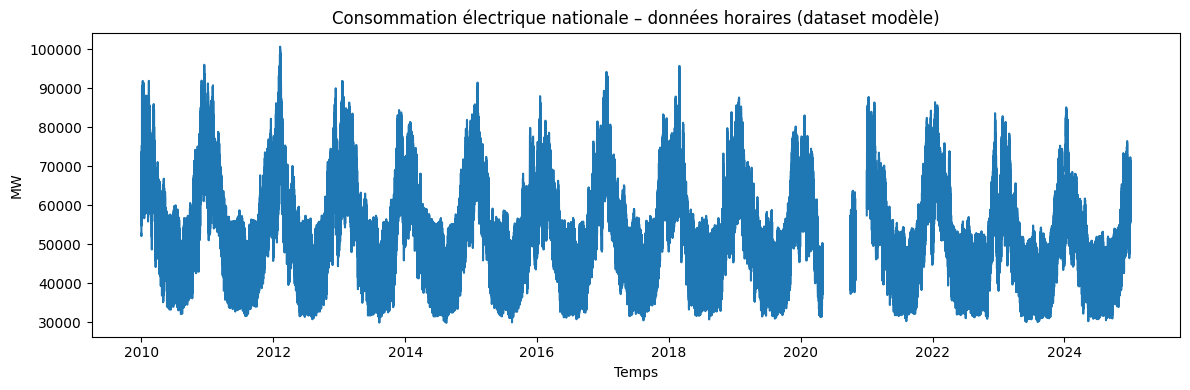

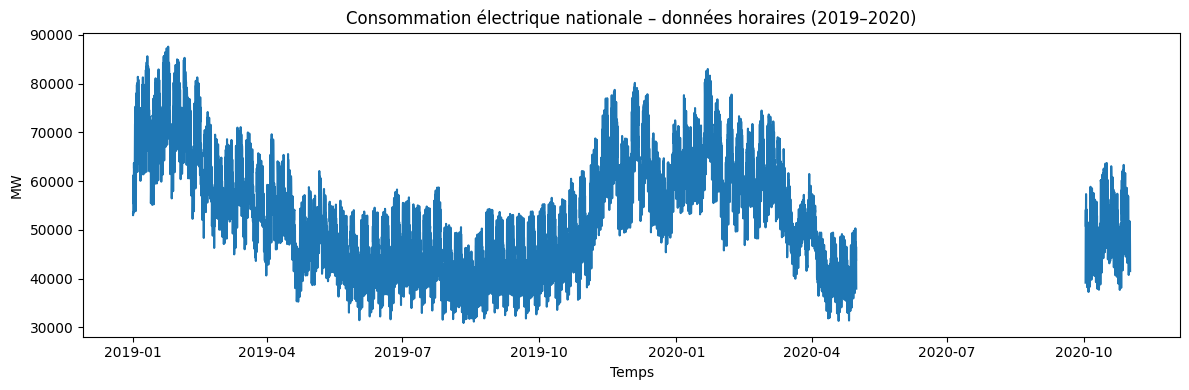

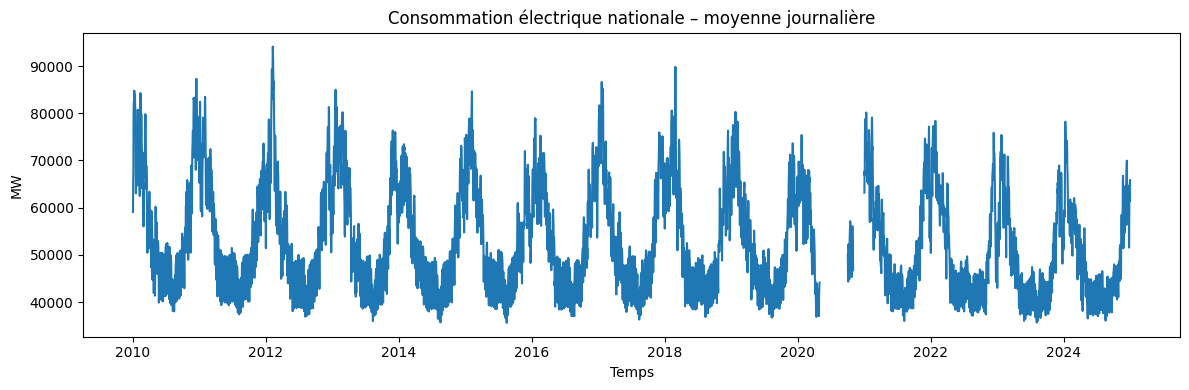

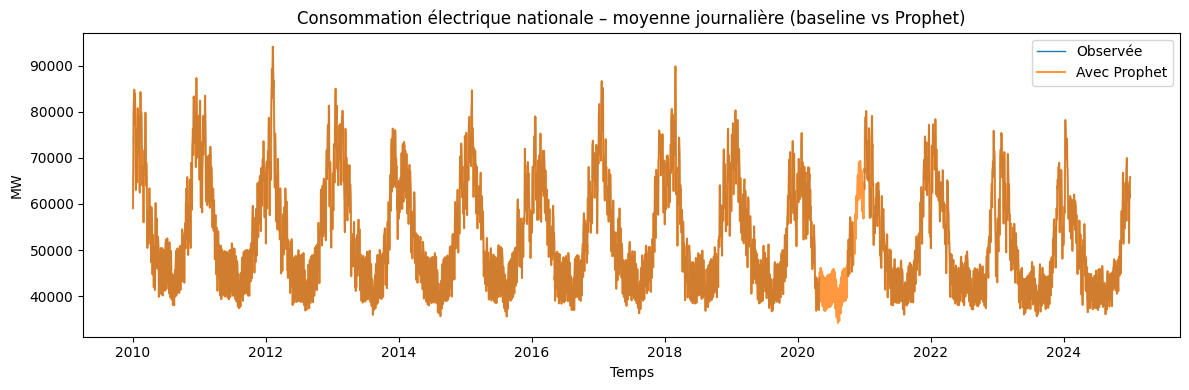

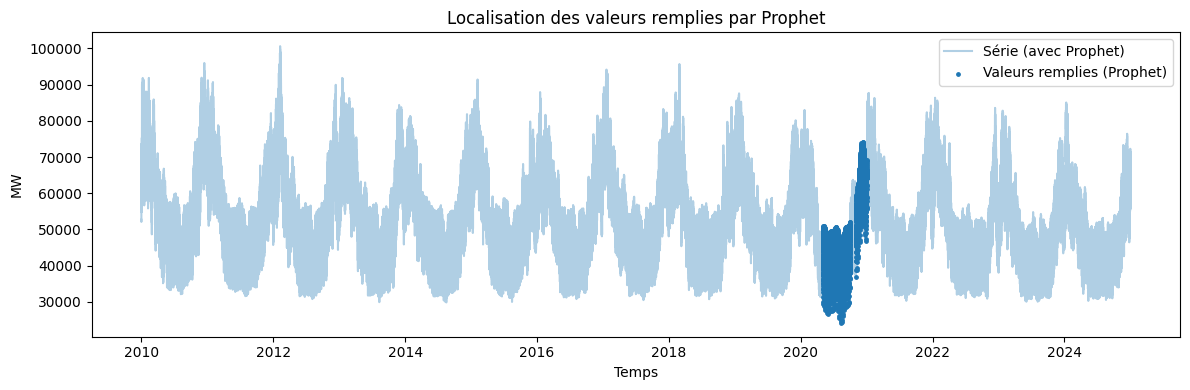

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PROCESSED = Path("/home/onyxia/france-grid-stress-prediction/data/processed")

# =========
# Load data
# =========
df_model = pd.read_parquet(DATA_PROCESSED / "dataset_model_hourly.parquet")
df_model["datetime"] = pd.to_datetime(df_model["datetime"])
df_model = df_model.sort_values("datetime")

# Optional: prophet-filled if available
pf_path = DATA_PROCESSED / "dataset_model_hourly_prophetfilled.parquet"
df_pf = None
if pf_path.exists():
    df_pf = pd.read_parquet(pf_path)
    df_pf["datetime"] = pd.to_datetime(df_pf["datetime"])
    df_pf = df_pf.sort_values("datetime")

# =========================
# 1) Full period (hourly)
# =========================
plt.figure(figsize=(12, 4))
plt.plot(df_model["datetime"], df_model["load_mw"])
plt.title("Consommation électrique nationale – données horaires (dataset modèle)")
plt.xlabel("Temps")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

# ==========================================
# 2) Zoom 2019–2020 (hourly, gap visibility)
# ==========================================
df_zoom = df_model[(df_model["datetime"] >= "2019-01-01") & (df_model["datetime"] <= "2020-12-31")]

plt.figure(figsize=(12, 4))
plt.plot(df_zoom["datetime"], df_zoom["load_mw"])
plt.title("Consommation électrique nationale – données horaires (2019–2020)")
plt.xlabel("Temps")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

# ==========================================
# 3) Full period (daily average, readable)
# ==========================================
df_daily = (
    df_model.set_index("datetime")["load_mw"]
    .resample("D")
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 4))
plt.plot(df_daily["datetime"], df_daily["load_mw"])
plt.title("Consommation électrique nationale – moyenne journalière")
plt.xlabel("Temps")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

# ======================================================
# 4) Daily comparison: observed vs Prophet-filled (if any)
# ======================================================
if df_pf is not None and "filled_by_prophet" in df_pf.columns:
    df_pf_daily = (
        df_pf.set_index("datetime")["load_mw"]
        .resample("D")
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(12, 4))
    plt.plot(df_daily["datetime"], df_daily["load_mw"], label="Observée", linewidth=1)
    plt.plot(df_pf_daily["datetime"], df_pf_daily["load_mw"], label="Avec Prophet", alpha=0.8)
    plt.title("Consommation électrique nationale – moyenne journalière (baseline vs Prophet)")
    plt.xlabel("Temps")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ======================================================
    # 5) Highlight only Prophet-filled points (hourly, on full)
    # ======================================================
    filled = df_pf[df_pf["filled_by_prophet"] == True].copy()

    plt.figure(figsize=(12, 4))
    plt.plot(df_pf["datetime"], df_pf["load_mw"], alpha=0.35, label="Série (avec Prophet)")
    plt.scatter(filled["datetime"], filled["load_mw"], s=6, label="Valeurs remplies (Prophet)")
    plt.title("Localisation des valeurs remplies par Prophet")
    plt.xlabel("Temps")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Prophet-filled dataset not found (or missing 'filled_by_prophet'). Skipping Prophet plots.")


In [29]:
def temporal_coverage(df, time_col="datetime"):
    return {
        "start": df[time_col].min(),
        "end": df[time_col].max(),
        "n_years": df[time_col].dt.year.nunique(),
    }


def missing_rate(df):
    return (
        df.isna()
        .mean()
        .mul(100)
        .round(2)
        .sort_values(ascending=False)
    )


In [35]:
cons_coverage = temporal_coverage(df_cons)
cons_missing = missing_rate(df_cons)

weather_coverage = temporal_coverage(df_weather_nat)
weather_missing = missing_rate(df_weather_nat)

model_coverage = temporal_coverage(df_model)
model_missing = missing_rate(df_model)

print()



## 📊 Data Quality Report

Cette section synthétise les principales caractéristiques et contrôles de qualité
des jeux de données utilisés avant l’étape de feature engineering.

### 🔹 Couverture temporelle

- **Consommation électrique**  
  - Période : {{cons_coverage.start}} → {{cons_coverage.end}}  
  - Nombre d’années couvertes : {{cons_coverage.n_years}}

- **Données météorologiques (nationales)**  
  - Période : {{weather_coverage.start}} → {{weather_coverage.end}}  
  - Nombre d’années couvertes : {{weather_coverage.n_years}}

- **Dataset final de modélisation**  
  - Période : {{model_coverage.start}} → {{model_coverage.end}}  
  - Nombre d’années couvertes : {{model_coverage.n_years}}

### 🔹 Fréquence temporelle

- Consommation : semi-horaire agrégée à l’heure
- Météo : horaire
- Dataset final : **horaire**

### 🔹 Valeurs manquantes

- Les valeurs manquantes sont limitées et directement liées aux données source.
- Aucune interpolation automatique n’a été appliquée au dataset de référence.
- Une rupture structurelle est identifiée entre **mai et septembre 2020**, due à
  l’absence de données de consommation dans les fichiers source.

### 🔹 Décisions méthodologiques

- Le dataset sans interpolation constitue la **référence principale** pour la modélisation.
- Une reconstruction contrefactuelle via Prophet est utilisée uniquement à des fins
  de comparaison méthodologique et non comme solution opérationnelle.

### 🔹 Conclusion

Les données sont cohérentes, traçables et prêtes pour l’étape de feature engineering.
Les principales limitations sont identifiées et documentées, sans impact sur la
validité méthodologique de l’analyse.


In [34]:
pd.DataFrame({
    "Consommation (%)": cons_missing,
    "Météo (%)": weather_missing,
    "Dataset modèle (%)": model_missing,
}).fillna(0)


,Consommation (%),Météo (%),Dataset modèle (%)
cloud_cover,0.0,0.0,0.00
datetime,0.0,0.0,0.00
diffuse_radiation,0.0,0.0,0.00
direct_radiation,0.0,0.0,0.00
load_mw,0.0,0.0,3.92
temperature_2m,0.0,0.0,0.00
wind_speed_10m,0.0,0.0,0.00
